# Flujo en 1D.

**Objetivo**. Revisar paso a paso cómo se realiza una simulación de flujo de aguas subterráneas en un dimensión usando el modelo GWF de MODFLOW 6.

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/RTWMA/blob/main/benchmarks/GWF/01_flujo_1D/01_flujo_1D.ipynb">Flujo en 1D</a> by <b>Luis M. de la Cruz Salas</b>b is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p> 

Este ejemplo se basa en: 

<a name="ref1"></a>
**<font color='Green'>[1] MODFLOW 6 – Example problems, MODFLOW 6 Development Team, with contributions from Chieh Ying Chen and Mike Toews 02/07/2024.**</font>  **32 MOC3D Problem 1**. (Archivo: `mf6examples.pdf` del directorio `doc` de la distribución de MODFLOW 6).

In [ ]:
# ejecuta esta celda si no se tiene instalado flopy.
#!pip install flopy

In [1]:
# Temporal, para agregar las rutas correctas
%run ../../src/xmf6/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 
sys.path[0]

'/Users/luiggi/GitSites/xmf6/src'

# Etapa 1. Ambiente para la simulación y datos de entrada.

## Paso 1. Importación de bibliotecas

In [2]:
import os, sys     # Intefaces con el sistema operativo.
import numpy as np # Manejo de arreglos numéricos multidimensionales
import matplotlib.pyplot as plt # Graficación

# Biblioteca y módulos de flopy
import flopy
from flopy.plot.styles import styles

# Extras para mf6 y flopy (módulo creado en este proyecto)
import xmf6

## Paso 2. Ambiente y salida para MODFLOW 6

In [24]:
ospar = xmf6.OSPar(
    ws  = os.getcwd() + '/output',     # Ruta del espacio de trabajo
    exe = '../../bin/macosarm/mf6', # Ejecutable
    fn  = 'flow',       # Nombre de la simulación
    hf  = 'flow.hds',   # Nombre del archivo para almacenar la carga hidráulica
    hbf = 'flow.bud'    # Nombre del archivo para almacenar el balance de la carga hidráulica
)

xmf6.nice_print(ospar, "MODFLOW 6 env y archivos de salida")


MODFLOW 6 env y archivos de salida
------------------------------
         Workspace = /Users/luiggi/GitSites/xmf6/examples/01_flujo_1D/output
     MODFLOW 6 exe = ../../bin/macosarm/mf6
         Flow name = flow        
         Head file = flow.hds    
     h Budget file = flow.bud    


## Paso 3. Parámetros de la simulación

### Discretización temporal

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Number of stress periods |1| | `tm_par['nper']` |
|Total time |120| s | `tm_par['total_time']` |
|Number of time steps| 1 | | `tm_par['nstp']`|
|Multiplier | 1 | | `tm_par['tsmult']`|

In [25]:
tdis = xmf6.TDis(
    perioddata = ((120, 1.0, 1.0),) # PERLEN, NSTP, TSMULT
)
xmf6.nice_print(tdis, 'Time discretization')


Time discretization
------------------------------
      NPER = 1       
TOTAL TIME = 120.00

PER     PERLEN     NSTP     TSMULT        Dt1
  1     120.00       1.00       1.00   1.20e+02


### Discretización espacial.

<img src="../figures/flow_mf6.png">

* El modelo de malla consiste de $1$ capa, $120$ columnas y $1$ renglón.
* La longitud del renglón es de $12$ [cm].
* La longitud de la columna es $0.1$ [cm].
* Con la información anterior se calcula el ancho del renglón, `DELC`, y de las columnas, `DELR`, que ambos casos debe ser $0.1$ [cm].
* La parte superior (`TOP`) de la celda es $1.0$ [cm] y la parte inferior (`BOTTOM`) es cero.
* La longitud de la capa es igual a $1.0$ [cm], valor que se calcula de `|TOP - BOTTOM|`.


|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Length of system (rows) |12.0| cm | `mesh.row_length` |
|Number of layers |1| | `mesh.nlay` |
|Number of rows |1| | `mesh.nrow` |
|Number of columns |120| | `mesh.ncol` |
|Column width |0.1| cm | `mesh.delr` |
|Row width |0.1| cm | `mesh.delc`|
|Top of the model |1.0| cm | `mesh.top`|
|Layer bottom elevation (cm) |0| cm | `mesh.bottom` |

In [26]:
mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system (cm)
    column_length = 0.1,  # Length of system (cm)
    top = 1.0,   # Top of the model (cm)
    bottom = 0,  # Layer bottom elevation (cm)
)

xmf6.nice_print(mesh.get_dict(), 'Space discretization')


Space discretization
------------------------------
          row_length = 12.0      
          col_length = 0.1       
          lay_length = 1.0       
                ncol = 120       
                nrow = 1         
                nlay = 1         
                delr = 0.1       
                delc = 0.1       
                dell = 1.0       
                 top = 1.0       
              bottom = 0.0       


### Unidades.

* Unidades de tiempo = s
* Unidades de longitud = cm

In [27]:
## Model Units
phpar = xmf6.PhysPar()

xmf6.nice_print(phpar, 'Units')


Units
------------------------------
                          time = seconds             
                        length = centimeters         


### Parámetros físicos.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Specific discharge |0.1| cm s$^{-1}$ | `ph_par['specific_discharge']` |
|Hydraulic conductivity |0.01| cm s$^{-1}$ | `ph_par['hydraulic_conductivity']` |
|Source concentration |1.0| unitless | `ph_par['source_concentration']` |

In [28]:
phpar.specific_discharge = 0.1 # Specific discharge ($cm s^{-1}$)
phpar.hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
phpar.source_concentration = 1.0  # Source concentration (unitless)

xmf6.nice_print(phpar, 'Physical parameters')


Physical parameters
------------------------------
                          time = seconds             
                        length = centimeters         
            specific discharge = 0.10000   
        hydraulic conductivity = 0.01000   
          source concentration = 1.00000   


# Etapa 2. Definición del modelo en MODFLOW 6.

## Paso 4. Definición de la simulación (`MFSimulation` object)

Recordemos que:

<img src="../figures/gwf_mf6.png" width=500px hspace="5" vspace="5" style="float: left;"/>
<img src="../figures/gwf_mf6_pack.png" width=500px hspace="5" vspace="5" style="float: ;"/>

In [29]:
sim = flopy.mf6.MFSimulation(
    sim_name = ospar.flow_name, 
    sim_ws   = ospar.workspace, 
    exe_name = ospar.mf6exe
)
print(sim)

sim_name = flow
sim_path = /Users/luiggi/GitSites/xmf6/examples/01_flujo_1D/output
exe_name = ../../bin/macosarm/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow





## Paso 5. Definición de la discretización temporal (`ModflowTDis` object)

In [30]:
flopy.mf6.ModflowTdis(sim, 
    nper = tdis.nper,
    perioddata = tdis.perioddata(), 
    time_units = phpar.time
)

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1.0, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', 'O'), ('tsmult', '<f8')]))



## Paso 6. Definición de la solución numérica (`ModflowIms` object)

In [31]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow




## Paso 7. Modelo de Flujo (ModflowGwf object)

In [32]:
gwf = flopy.mf6.ModflowGwf(sim, 
    modelname  = ospar.flow_name, 
    save_flows = True
)
print(gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .




## Paso 7. Paquete: discretización espacial (`ModflowGwfdis` object)

In [33]:
dis = flopy.mf6.ModflowGwfdis(gwf,
    length_units = phpar.length,
    nlay = mesh.nlay,
    nrow = mesh.nrow,
    ncol = mesh.ncol,
    delr = mesh.delr,
    delc = mesh.delc,
    top  = mesh.top,
    botm = mesh.bottom,
)
print(dis)

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(120)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0.0}





## Paso 8. Paquete: condiciones iniciales (`ModflowGwfic` object)



In [34]:
ic = flopy.mf6.ModflowGwfic(gwf, 
    strt=1.0 # Initial head
) 
print(ic)

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 1.0}





## Paso 9. Paquete: propiedades de flujo en los nodos (`ModflowGwfnpd` object)

In [35]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
    save_specific_discharge = True,
    save_saturation = True,
    icelltype = 0,
    k = phpar.hydraulic_conductivity,
)
print(npf)

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.1}





## Paso 10. Paquete: CHD (`ModflowGwfchd` object)

In [36]:
chd = flopy.mf6.ModflowGwfchd(gwf, 
    stress_period_data=[[(0, 0, mesh.ncol - 1), 1.0]]  # Node, Constant value
) 
print(chd)

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{internal}
(   cellid_layer  cellid_row  cellid_column  head
0             0           0            119   1.0)





## Paso 11. Paquete: Pozos (`ModflowGwfwel` object)

In [37]:
q   = phpar.specific_discharge * mesh.delc * mesh.delr * mesh.top
aux = phpar.source_concentration

wel = flopy.mf6.ModflowGwfwel(gwf,
    stress_period_data = [[(0, 0, 0), q, aux,]],
    pname = "WEL-1",
    auxiliary = ["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = flow.wel
package_type = wel
model_or_simulation_package = model
model_name = flow

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{internal}
(   cellid_layer  cellid_row  cellid_column      q  CONCENTRATION
0             0           0              0  0.001            0.1)





## Paso 12. Paquete: salida (`ModflowGwfoc` object)

In [38]:
oc = flopy.mf6.ModflowGwfoc(gwf,
    head_filerecord   = ospar.head_file,
    budget_filerecord = ospar.hbudget_file,
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Paso 13. Escritura de los archivos de entrada para MODFLOW 6

In [39]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


## Paso 14. Ejecución de la simulación.

In [41]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../bin/macosarm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 17:58:17 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Governme

(True, [])

# Etapa 3. Postprocesamiento de la solución.

## Paso 15. Lectura y transformación de resultados

In [43]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(
    os.path.join(ospar.workspace, 
                 ospar.head_file)).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(
    os.path.join(ospar.workspace, 
                 ospar.hbudget_file),
    precision='double'
)
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [44]:
# Verificamos el tipo y dimensiones de los arreglos donde
# están almacenados la carga hidráulica, el BUDGET, y la velocidad.
print('Head : ', type(head), head.shape)
print('Budget : ', type(bud), bud.shape)
print('spdis : ', type(spdis), spdis.shape)
print('qx : ', type(qx), qx.shape)
print('qy : ', type(qy), qy.shape)
print('qz : ', type(qz), qz.shape)

Head :  <class 'numpy.ndarray'> (1, 1, 120)
Budget :  <class 'flopy.utils.binaryfile.CellBudgetFile'> (np.int32(1), np.int32(1), np.int32(120))
spdis :  <class 'numpy.rec.recarray'> (120,)
qx :  <class 'numpy.ndarray'> (1, 1, 120)
qy :  <class 'numpy.ndarray'> (1, 1, 120)
qz :  <class 'numpy.ndarray'> (1, 1, 120)


In [45]:
print(head.shape, '\n', head)

(1, 1, 120) 
 [[[2.19 2.18 2.17 2.16 2.15 2.14 2.13 2.12 2.11 2.1  2.09 2.08 2.07 2.06
   2.05 2.04 2.03 2.02 2.01 2.   1.99 1.98 1.97 1.96 1.95 1.94 1.93 1.92
   1.91 1.9  1.89 1.88 1.87 1.86 1.85 1.84 1.83 1.82 1.81 1.8  1.79 1.78
   1.77 1.76 1.75 1.74 1.73 1.72 1.71 1.7  1.69 1.68 1.67 1.66 1.65 1.64
   1.63 1.62 1.61 1.6  1.59 1.58 1.57 1.56 1.55 1.54 1.53 1.52 1.51 1.5
   1.49 1.48 1.47 1.46 1.45 1.44 1.43 1.42 1.41 1.4  1.39 1.38 1.37 1.36
   1.35 1.34 1.33 1.32 1.31 1.3  1.29 1.28 1.27 1.26 1.25 1.24 1.23 1.22
   1.21 1.2  1.19 1.18 1.17 1.16 1.15 1.14 1.13 1.12 1.11 1.1  1.09 1.08
   1.07 1.06 1.05 1.04 1.03 1.02 1.01 1.  ]]]


In [46]:
print(qx.shape, '\n', qx)

(1, 1, 120) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


## Paso 16. Visualización de resultados.

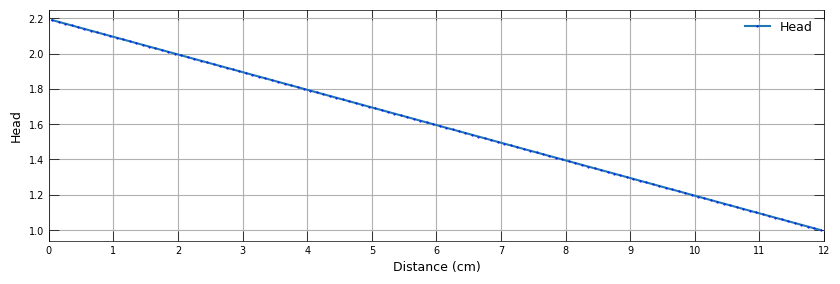

In [47]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'
    x, _, _ = mesh.get_coords()
    plt.figure(figsize=(10,3))
    plt.plot(x, head[0, 0], marker=".", ls ="-", mec="blue", mfc="none", markersize="1", label = 'Head')
    plt.xlim(0, 12)
    plt.xticks(ticks=np.linspace(0, mesh.row_length,13))
    plt.xlabel("Distance (cm)")
    plt.ylabel("Head")
    plt.legend()
    plt.grid()
    plt.show()

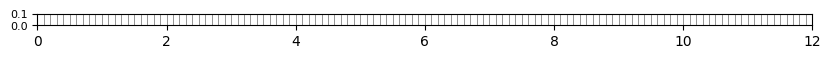

In [48]:
plt.figure(figsize=(10,0.15))
ax = plt.gca()
pmv0 = flopy.plot.PlotMapView(gwf, ax=ax)
pmv0.plot_grid(colors='dimgray', lw=0.5)
plt.yticks(ticks=[0, 0.1],fontsize=8)

plt.show()
